In [1]:

# pip install mysql-connector-python


In [2]:
# import pandas as pd
# import mysql.connector
# import os

# # List of CSV files and their corresponding table names
# csv_files = [
#     ('customers.csv', 'customers'),
#     ('orders.csv', 'orders'),
#     ('sellers.csv', 'sellers'),
#     ('products.csv', 'products'),
#     ('geolocation.csv', 'geolocation'),
#     ('payments.csv', 'payments'),
#     ('order_items.csv','order_items')# Added payments.csv for specific handling
# ]

# # Connect to the MySQL database
# conn = mysql.connector.connect(
#     host='localhost',
#     user='root',
#     password='9605',
#     database='ecommerce'
# )
# cursor = conn.cursor()

# # Folder containing the CSV files
# folder_path = 'C:/Users/ZAINAB/Downloads/archive'

# def get_sql_type(dtype):
#     if pd.api.types.is_integer_dtype(dtype):
#         return 'INT'
#     elif pd.api.types.is_float_dtype(dtype):
#         return 'FLOAT'
#     elif pd.api.types.is_bool_dtype(dtype):
#         return 'BOOLEAN'
#     elif pd.api.types.is_datetime64_any_dtype(dtype):
#         return 'DATETIME'
#     else:
#         return 'TEXT'

# for csv_file, table_name in csv_files:
#     file_path = os.path.join(folder_path, csv_file)
    
#     # Read the CSV file into a pandas DataFrame
#     df = pd.read_csv(file_path)
    
#     # Replace NaN with None to handle SQL NULL
#     df = df.where(pd.notnull(df), None)
    
#     # Debugging: Check for NaN values
#     print(f"Processing {csv_file}")
#     print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

#     # Clean column names
#     df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

#     # Generate the CREATE TABLE statement with appropriate data types
#     columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
#     create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
#     cursor.execute(create_table_query)

#     # Insert DataFrame data into the MySQL table
#     for _, row in df.iterrows():
#         # Convert row to tuple and handle NaN/None explicitly
#         values = tuple(None if pd.isna(x) else x for x in row)
#         sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
#         cursor.execute(sql, values)

#     # Commit the transaction for the current CSV file
#     conn.commit()

# # Close the connection
# conn.close()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='9605',
    database='ecommerce'
)
cursor = conn.cursor()

#query


In [4]:
#LIST all the unique cities where customers are located
query= """select distinct(customer_city) from customers"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data)
df
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [5]:
#count the number of orders placed in 2017
query= """select count(order_id) from orders where year(order_purchase_timestamp)=2017"""
cursor.execute(query)
data=cursor.fetchall()
"TOTAL ORDERS PLACED IN 2017",data

('TOTAL ORDERS PLACED IN 2017', [(135303,)])

In [6]:
#TOTAL SALES PER CATEGORY
query= """select upper(products.product_category) as category , round(sum(payments.payment_value),2) as sales
from products join order_items 
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category
"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data,columns=["Category","sales"])
df

,Category,sales
0,PERFUMERY,9121295.88
1,FURNITURE DECORATION,25743175.05
2,TELEPHONY,8763876.91
3,BED TABLE BATH,30825966.08
4,AUTOMOTIVE,15341297.96
...,...,...
69,CDS MUSIC DVDS,21589.74
70,LA CUISINE,52443.54
71,FASHION CHILDREN'S CLOTHING,14142.06
72,PC GAMER,39139.74


In [7]:
#calc percentage of order that were paid in installements
query= """select (sum(case when payment_installments>=1 then 1
else 0 end))/count(*)*100 from payments
"""
cursor.execute(query)
data=cursor.fetchall()
data

[(Decimal('99.9981'),)]

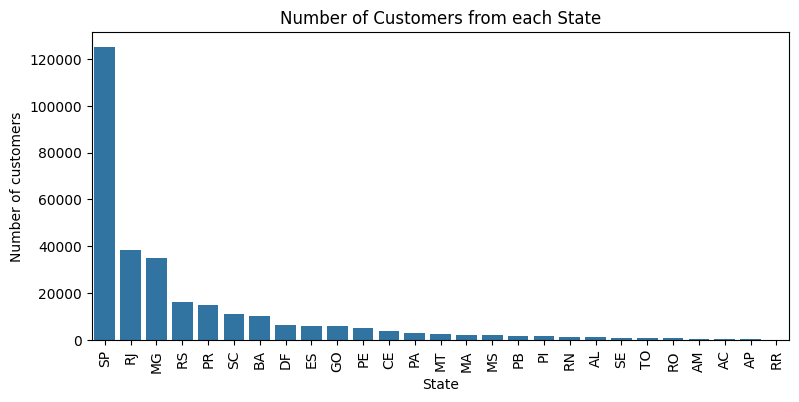

In [8]:
#count the number of customers from each state
query= """select customer_state, count(customer_id) from customers
group by customer_state
"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data, columns=["State","Number of customers"])
df=df.sort_values(by = "Number of customers",ascending=False)
plt.figure(figsize=(9,4))
sns.barplot(x=df["State"],y=df["Number of customers"],data=df)
plt.xticks(rotation=90)
plt.title("Number of Customers from each State")
plt.show()

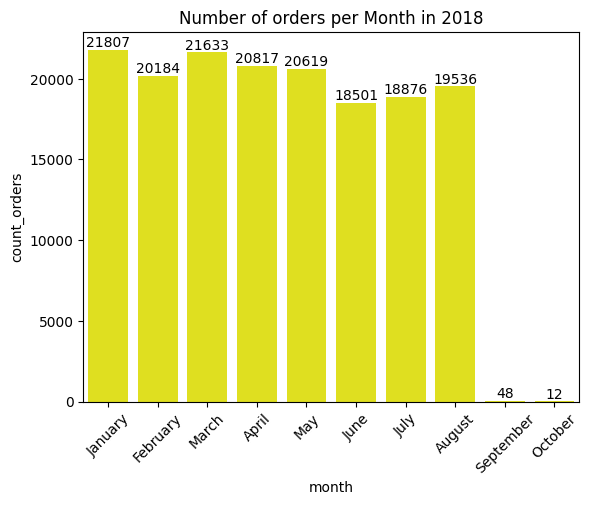

In [9]:
#Calculate the number of orders per month in 2018. 
query= """select monthname(order_purchase_timestamp) as Month ,count(order_id)
from orders where year(order_purchase_timestamp)=2018
group by Month
"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data, columns=["month","count_orders"])
o=["January","February","March","April","May","June","July","August","September","October"]

ax=sns.barplot(x=df["month"], y=df["count_orders"], data=df, order=o, color="yellow")
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.title("Number of orders per Month in 2018")
plt.show()

In [10]:
#Find the average number of products per order, grouped by customer city.
query= """with count_per_order as (select orders.order_id,orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) avg_order
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city
order by avg_order desc
"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data,columns=["city","avg_order"])
df

,city,avg_order
0,padre carvalho,42.00
1,celso ramos,39.00
2,datas,36.00
3,candido godoi,36.00
4,matias olimpio,30.00
...,...,...
4105,sao mamede,6.00
4106,sambaiba,6.00
4107,japaratuba,6.00
4108,tuiuti,6.00


In [11]:
#Calculate the percentage of total revenue contributed by each product category.
query= """select
products.product_category,(sum(payments.payment_value)/(select sum(payment_value) from payments))*100 as sales
from payments join order_items
on payments.order_id=order_items.order_id
join products
on products.product_id=order_items.product_id
group by products.product_category
order by sales desc

"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data,columns=["product category","percentage revenue contributed"])
df.head(5)

,product category,percentage revenue contributed
0,bed table bath,64.185172
1,HEALTH BEAUTY,62.117048
2,computer accessories,59.416945
3,Furniture Decoration,53.601892
4,Watches present,53.565923


In [12]:
#Identify the correlation between product price and the number of times a product has been purchased.

query= """select products.product_category,count(order_items.product_id),round(avg(order_items.price),2)
from products
join order_items on
products.product_id=order_items.product_id
group by products.product_category

"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data,columns=["product category","total times product purchased","product price"])
arr1=df["total times product purchased"]
arr2=df["product price"]
# df.head(5)
a= np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is", a[0][1])

the correlation between price and number of times a product has been purchased is -0.10631514167157569


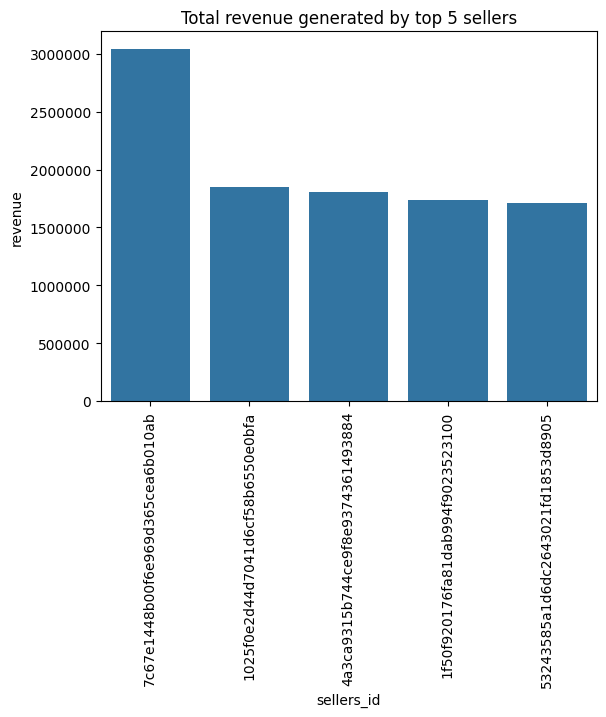

In [13]:
#Calculate the total revenue generated by each seller, and rank them by revenue.
query= """select *,dense_rank() over (order by revenue desc)
from (
select order_items.seller_id,sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id=payments.order_id 
group by order_items.seller_id) as a
"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data,columns=["sellers_id","revenue", "rank"])
pd.set_option('display.float_format', '{:.0f}'.format)
plt.ticklabel_format(style='plain', axis='y') 

df=df.head(5)
sns.barplot(x=df["sellers_id"],y=df["revenue"],data=df)
plt.xticks(rotation=90)
plt.title("Total revenue generated by top 5 sellers")
plt.show()

In [21]:
#Calculate the moving average of order values for each customer over their order history.

query= """select customer_id, order_purchase_timestamp, payment, 
avg(payment) over (partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as mov_avg 
from
(select orders.customer_id,orders.order_purchase_timestamp, payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id) as a

"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data,columns=["Customer id","order_purchase_timestamp","payment","moving average"])
df

,Customer id,order_purchase_timestamp,payment,moving average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,115,115
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,115,115
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,115,115
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,115,115
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,115,115
...,...,...,...,...
934969,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18,18
934970,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18,18
934971,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18,18
934972,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18,18


In [28]:
#Calculate the cumulative sales per month for each year.

query= """
select years,months,payment, sum(payment) 
over(order by years,months) as cumulative_sales 
from 
(select year(orders.order_purchase_timestamp) as years,
month(order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment 
from orders join payments 
on orders.order_id=payments.order_id 
group by years,months order by years,months) as a

"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data,columns=["Year","Month","payment","Cumulative_Sales"])
df

,Year,Month,payment,Cumulative_Sales
0,2016,9,2270,2270
1,2016,10,531814,534084
2,2016,12,177,534261
3,2017,1,1246392,1780653
4,2017,2,2627172,4407826
5,2017,3,4048772,8456598
6,2017,4,3760092,12216690
7,2017,5,5336269,17552960
8,2017,6,4601487,22154447
9,2017,7,5331446,27485893


In [31]:
#Calculate the year-over-year growth rate of total sales.

query= """
with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment 
from orders join payments 
on orders.order_id=payments.order_id 
group by years order by years) 

select years,((payment-lag(payment,1) over (order by years))/lag(payment,1) over (order by years))*100 from a

"""
cursor.execute(query)
data=cursor.fetchall()
df=pd.DataFrame(data,columns=["Year","Year over year Growth percentage"])
df

,Year,Year over year Growth percentage
0,2016,NaN
1,2017,12113
2,2018,20


In [34]:
#Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cursor.execute(query)
data = cursor.fetchall()

print(data)
print(f"No customer has ordered again in next 6 months after their first purchase")

[(None,)]
No customer has ordered again in next 6 months after their first purchase


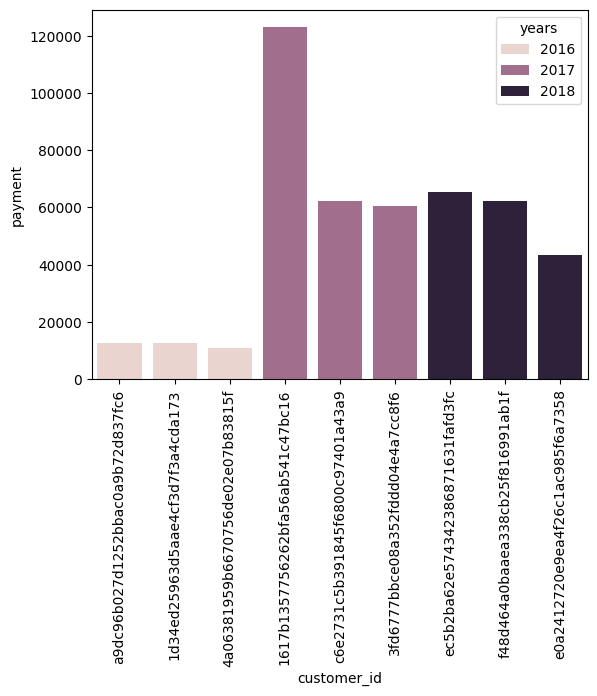

In [37]:
#Identify the top 3 customers who spent the most money in each year.
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["years","customer_id","payment","rank"])
sns.barplot(x = "customer_id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()